In [1]:
%load_ext autoreload

In [2]:
%autoreload 1

%aimport CTR_Dominating_Stiffness
from CTR_Dominating_Stiffness import CTR_DomStiff
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

Define the pipe

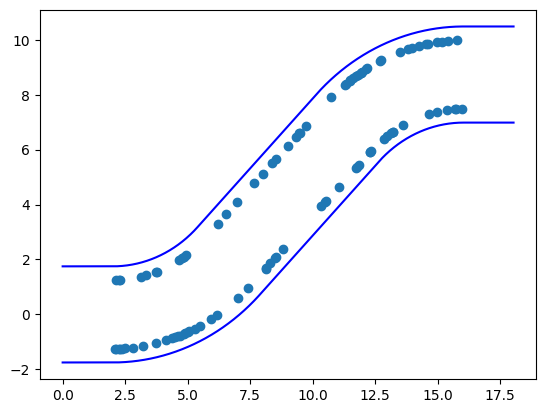

In [3]:
tube_diameter = 3.5 # diameter of tube (cm)
tube_radius_of_curvature = 6.5 # radius of curvature of tube (cm)
tube_curve_length = 5.16 # length of curved section of tube in middle (cm)
middle_length = 6.8 # length of middle section of tube (cm)
end_lengths = 2.0 # length of straight sections at ends of tube (cm)

class Pipe_Workspace:
    def __init__(self, diameter, radius_of_curvature, curve_length, middle_length, end_lengths):
        self.diameter = diameter
        self.radius_of_curvature = radius_of_curvature
        self.curve_length = curve_length
        self.middle_length = middle_length
        self.end_lengths = end_lengths
        self.theta = curve_length / radius_of_curvature
        self.x_final = 2*end_lengths + 2*radius_of_curvature*np.sin(self.theta) + middle_length*np.cos(self.theta)
        
    def get_tube_bounds(self, x):
        r_large = self.radius_of_curvature + self.diameter/2
        r_small = self.radius_of_curvature - self.diameter/2

        upper_x = [0]
        upper_x.append(self.end_lengths)
        upper_x.append(self.end_lengths + r_small*np.sin(self.theta))
        upper_x.append(self.end_lengths + r_small*np.sin(self.theta) + self.middle_length*np.cos(self.theta))
        upper_x.append(self.x_final - self.end_lengths)
        lower_x = [0]
        lower_x.append(self.end_lengths)
        lower_x.append(self.end_lengths + r_large*np.sin(self.theta))
        lower_x.append(self.end_lengths + r_large*np.sin(self.theta) + self.middle_length*np.cos(self.theta))
        lower_x.append(self.x_final - self.end_lengths)

        conditions = []
        upper = []
        lower = []
        
        upper.append(self.diameter/2)
        upper.append(lambda x: -np.sqrt(r_small**2 - (x - self.end_lengths)**2) + self.radius_of_curvature)
        upper.append(lambda x: np.tan(self.theta)*(x - upper_x[2]) + r_small*(1-np.cos(self.theta)) + self.diameter/2)
        upper.append(lambda x: np.sqrt(r_large**2 - (x - upper_x[4])**2) - self.radius_of_curvature + 2*self.radius_of_curvature*(1-np.cos(self.theta)) + self.middle_length*np.sin(self.theta))
        upper.append(2*self.radius_of_curvature*(1-np.cos(self.theta)) + self.middle_length*np.sin(self.theta) + self.diameter/2)
        lower.append(-self.diameter/2)
        lower.append(lambda x: -np.sqrt(r_large**2 - (x - self.end_lengths)**2) + self.radius_of_curvature)
        lower.append(lambda x: np.tan(self.theta)*(x - lower_x[2]) + r_large*(1-np.cos(self.theta)) - self.diameter/2)
        lower.append(lambda x: np.sqrt(r_small**2 - (x - lower_x[4])**2) - self.radius_of_curvature + 2*self.radius_of_curvature*(1-np.cos(self.theta)) + self.middle_length*np.sin(self.theta))
        lower.append(2*self.radius_of_curvature*(1-np.cos(self.theta)) + self.middle_length*np.sin(self.theta) - self.diameter/2)
        
        conditions_list = []
        for changes_x in [upper_x, lower_x]:
            conditions = []
            conditions.append((x <= changes_x[1]))
            conditions.append((x > changes_x[1]) & (x <= changes_x[2]))
            conditions.append((x > changes_x[2]) & (x <= changes_x[3]))
            conditions.append((x > changes_x[3]) & (x <= changes_x[4]))
            conditions.append((x > changes_x[4]))
            conditions_list.append(conditions)
        
        return np.piecewise(x, conditions_list[0], upper), np.piecewise(x, conditions_list[1], lower)
    
    def tube_shape(self, dpts=1000):
        x = np.linspace(0, self.x_final, dpts)
        upper, lower = self.get_tube_bounds(x)
        return x, upper, lower
    
    def get_test_locations(self, num_tests, delta_x=0.01):
        min_focal_length = 0.5
        dx = np.ones(num_tests) * delta_x
        x = np.random.uniform(self.end_lengths, self.x_final - self.end_lengths, num_tests)
        side = np.random.randint(0, 2, num_tests)
        upper, lower = self.get_tube_bounds(x)
        y = np.where(side, upper, lower)
        y2upper, y2lower = self.get_tube_bounds(x + dx)
        dy = np.where(side, y2upper, y2lower) - y
        direction = np.where(side, 1, -1)[np.newaxis,:] * np.vstack([-dy, dx])
        direction /= np.linalg.norm(direction, axis=0)
        coordinates = np.vstack([x, y])
        coordinates -= min_focal_length * direction
        return np.vstack([coordinates, direction])
    
Pipe = Pipe_Workspace(tube_diameter, tube_radius_of_curvature, tube_curve_length, middle_length, end_lengths)
x, upper, lower = Pipe.tube_shape()
test_locs = Pipe.get_test_locations(100)
plt.plot(x, upper, c='b')
plt.plot(x, lower, c='b')
plt.scatter(test_locs[0,:], test_locs[1,:])
plt.show()


Optimization Method

In [4]:
# Specify a list of (test (x,y)-coordinate, the normal direction)'s
test_targets = Pipe.get_test_locations(5)

# Specify a function that takes in the robot shape and the pipe profile and return a cost value
def cost_boundary(robot_shape, pipe_profile) -> float:
    y_tube_upper, y_tube_lower = pipe_profile.get_tube_bounds(robot_shape[:,0])
    error = robot_shape[:,1] * 0.
    error[robot_shape[:,1] > y_tube_upper] = robot_shape[:,1][robot_shape[:,1] > y_tube_upper] - y_tube_upper[robot_shape[:,1] > y_tube_upper]
    error[robot_shape[:,1] < y_tube_lower] = y_tube_lower[robot_shape[:,1] < y_tube_lower] - robot_shape[:,1][robot_shape[:,1] < y_tube_lower]
    return np.sum(error**2)

# OPTIONAL: specify a custom cost for position and direction error 
# (for inverse kinematic, and also the tubes optimization as a whole)
def cost_inv_custom(target_xy, target_dir, tip_xy, normal_dir) -> float:
    return np.linalg.norm(tip_xy-target_xy)**2+ np.linalg.norm(normal_dir-target_dir)**2

# Specify a function that combine the (position error & angular cost) with (boundary cost) to give a final cost
def combined_cost(cost_inv, cost_bound) -> float:
    return cost_inv + cost_bound

def objective_CTR(CurvedLengths_Kappa):
    Curved_Lengths = CurvedLengths_Kappa[0:3]
    Kappas = CurvedLengths_Kappa[3:6]
    Lengths = CurvedLengths_Kappa[6:9]
    CTR = CTR_DomStiff(Lengths, Curved_Lengths, Kappas, Pipe)
    final_cost = 0
    for i in range(test_targets.shape[1]):
        target_xy = test_targets[:2,i]
        target_dir = test_targets[2:,i]
        best_inverse_result = CTR.inverse_kin(target_xy, target_dir, cost_inv= cost_inv_custom)[0]
        (kin_lengths, thetas, cost_inv) = best_inverse_result
        robot_shape = CTR.get_shape(kin_lengths, thetas) # perhaps, this should be calculated simultaneously with cost_inv
        cost_bound = cost_boundary(robot_shape, CTR.Pipe_Profile)
        final_cost += combined_cost(cost_inv, cost_bound)
    # Take average across all points   
    final_cost = final_cost/test_targets.shape[1]
    # curvature cost
    final_cost += 0.1*(CurvedLengths_Kappa[3]**2+CurvedLengths_Kappa[4]**2+CurvedLengths_Kappa[5]**2)
    # max extension length cost
    final_cost += 0.0002*(np.sum(CurvedLengths_Kappa[6:9])**2+np.sum(CurvedLengths_Kappa[6:8])**2+CurvedLengths_Kappa[6]**2)
    return final_cost

In [5]:
# Initial guess
initial_params = [3,3,3,0.1,0.1,0.5,7,7,7] # --> [L3c, L2c, L1c, k3, k2, k1, L3, L2, L1]

# Optimization bounds
eps = 1e-3
opt_bounds = [(0, 20), (0, 20), (0, 20), (eps,2), (eps,2), (eps,2), (0, 20), (0, 20), (0, 20)]

# Obtain the optimized Curved Lengths and Curvatures
opt_result = minimize(objective_CTR, initial_params, method="Nelder-Mead", bounds=opt_bounds)
# opt_result = minimize(objective_CTR, initial_params, method="Nelder-Mead")

In [15]:
# optimization via GP
from skopt import gp_minimize

# Initial guess
initial_params = [3,3,3,0.1,0.1,0.5,7,7,7] # --> [L3c, L2c, L1c, k3, k2, k1, L3, L2, L1]

# Optimization bounds
eps = 1e-3
opt_bounds = [(0, 20), (0, 20), (0, 20), (eps,2), (eps,2), (eps,2), (0, 20), (0, 20), (0, 20)]

# Obtain the optimized Curved Lengths and Curvatures
opt_result = gp_minimize(objective_CTR, opt_bounds, n_calls=400, n_random_starts=10, acq_func="LCB", x0=initial_params, n_jobs=-1)
# opt_result = gp_minimize(objective_CTR, opt_bounds, n_calls=10, n_random_starts=1)

c:\Users\tbwil\Documents\Capstone\tube_specs\CTR_Dominating_Stiffness.py:94: OptimizeWarning: Initial guess is not within the specified bounds
  opt_result = minimize(objective, initial_kin_lengths, method="Nelder-Mead",
c:\Users\tbwil\Documents\Capstone\tube_specs\CTR_Dominating_Stiffness.py:94: OptimizeWarning: Initial guess is not within the specified bounds
  opt_result = minimize(objective, initial_kin_lengths, method="Nelder-Mead",
c:\Users\tbwil\Documents\Capstone\tube_specs\CTR_Dominating_Stiffness.py:94: OptimizeWarning: Initial guess is not within the specified bounds
  opt_result = minimize(objective, initial_kin_lengths, method="Nelder-Mead",
c:\Users\tbwil\Documents\Capstone\tube_specs\CTR_Dominating_Stiffness.py:94: OptimizeWarning: Initial guess is not within the specified bounds
  opt_result = minimize(objective, initial_kin_lengths, method="Nelder-Mead",
c:\Users\tbwil\Documents\Capstone\tube_specs\CTR_Dominating_Stiffness.py:94: OptimizeWarning: Initial guess is not w

In [16]:
# retrieve results
Curved_Lengths_opt = opt_result.x[0:3]
Kappas_opt = opt_result.x[3:6]
Lengths_opt = opt_result.x[6:9]
print(opt_result.x)
print(opt_result.fun)

[19, 0, 1, 0.3583924831566304, 0.4547375047670346, 1.1055686907158009, 9, 15, 1]
0.41586919864837135


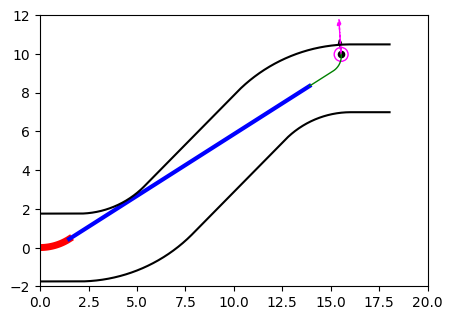

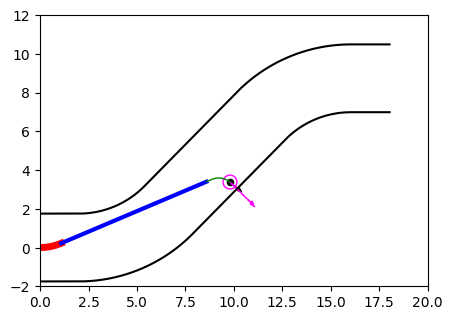

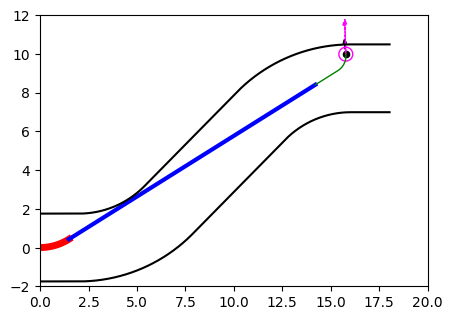

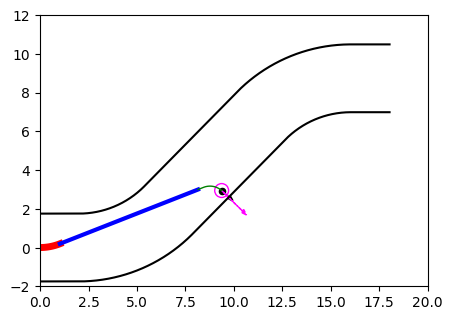

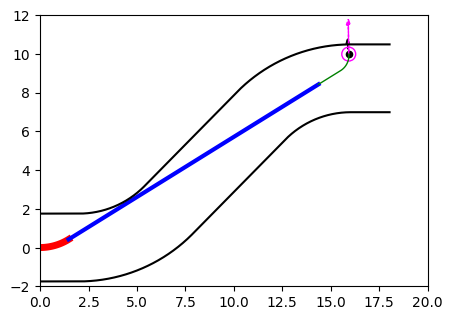

In [17]:
# visualize the results on the training set
CTR_opt = CTR_DomStiff(Lengths_opt, Curved_Lengths_opt, Kappas_opt, Pipe)
for i in range(test_targets.shape[1]):
    target_xy_top = test_targets[:2,i]
    target_dir_top = test_targets[2:,i]
    inverse_results_top_opt = CTR_opt.inverse_kin(target_xy_top, target_dir_top)
    CTR_opt.plot_inverse(target_xy_top, target_dir_top, inverse_results_top_opt, num_sol_to_plot=1)

<AxesSubplot: >

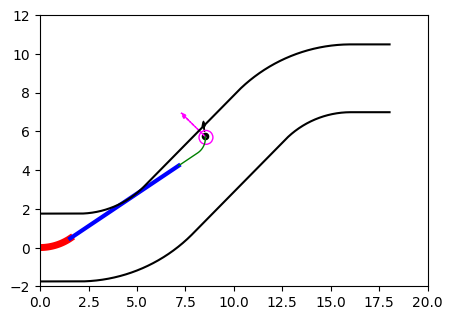

In [18]:
# Test on a new random point
test_loc = Pipe.get_test_locations(1)
target_xy_top = test_loc[:2,0]
target_dir_top = test_loc[2:,0]
inverse_results_top = CTR_opt.inverse_kin(target_xy_top, target_dir_top, cost_inv_custom)
CTR_opt.plot_inverse(target_xy_top, target_dir_top, inverse_results_top, num_sol_to_plot=1)